[Predicting the Direction of Stock Market Index Movement Using an Optimized Artificial Neural Network Model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4873195/)

[A beginner’s guide to Linear Regression in Python with Scikit-Learn](https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f)

* Implement 2 features from the paper and visualize the price and the features in the same graph. Do a regression based on the features, forecast 1-day ahead. 

* Plot (as a line) the regression and expected output, make the plot zoomable. What do you find, is the regression good? Comment in notebbok. 

* Add 2 more features from the “Type 2” category of features presented in the paper (not MA). 

* Calculate the error for the regression, use sMAPE/MAPE and MASE error measurements 

* Design a decision for when to invest and when to sell based on your regression. The decision can be naïve, meaning you can create a rule (if .. X .. then .. Y). Compare correctness for the result between train and test data. Follow the paper for calculating hit ratio % (buy or sell) 

In [1]:
%load_ext watermark
%watermark -p numpy,pandas,matplotlib,seaborn,sklearn,datetime,yfinance,plotly

numpy 1.15.4
pandas 0.25.1
matplotlib 2.2.3
seaborn 0.9.0
sklearn 0.20.0
datetime unknown
yfinance 0.1.45
plotly 4.1.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [3]:
import datetime
import plotly.express as px
import yfinance as yf

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression,ElasticNetCV
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [5]:
# a function for extracting the different stock markets
def GET(tickers,startdate,enddate):
    def DATA(ticker):
        return yf.download(ticker,start=startdate,end=enddate)
    datas = map(DATA,tickers)
    return pd.concat(datas,keys=tickers,names=["Ticker","Date"])

In [23]:
# extracting stock markets
tickers = ["GOOG","MSFT","FB","AAPL","IBM"]
startdate = "2000-01-01"
enddate = datetime.date.today()

all_data = GET(tickers,startdate,enddate)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [24]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20617 entries, (GOOG, 2004-08-19 00:00:00) to (IBM, 2019-10-15 00:00:00)
Data columns (total 6 columns):
Open         20617 non-null float64
High         20617 non-null float64
Low          20617 non-null float64
Close        20617 non-null float64
Adj Close    20617 non-null float64
Volume       20617 non-null int64
dtypes: float64(5), int64(1)
memory usage: 1.0+ MB


In [25]:
all_data

Open    High     Low   Close  Adj Close    Volume
Ticker Date                                                           
GOOG   2004-08-19   49.81   51.84   47.80   49.98      49.98  44871300
       2004-08-20   50.32   54.34   50.06   53.95      53.95  22942800
       2004-08-23   55.17   56.53   54.32   54.50      54.50  18342800
       2004-08-24   55.41   55.59   51.59   52.24      52.24  15319700
       2004-08-25   52.28   53.80   51.75   52.80      52.80   9232100
...                   ...     ...     ...     ...        ...       ...
IBM    2019-10-09  139.77  140.33  138.79  139.67     139.67   2620800
       2019-10-10  139.77  141.78  139.56  141.13     141.13   2593700
       2019-10-11  142.77  144.50  142.61  142.76     142.76   2996800
       2019-10-14  142.31  142.43  141.32  142.04     142.04   2309500
       2019-10-15  142.54  143.72  141.81  143.00     143.00   3025500

[20617 rows x 6 columns]

In [26]:
# seperate AAPL information
aapl_df = all_data.reset_index(level=0)
aapl_df = aapl_df[aapl_df.Ticker=="AAPL"]
aapl_df = aapl_df.drop(["Ticker"],axis=1)
aapl_df

Open    High     Low   Close  Adj Close     Volume
Date                                                            
1999-12-31    3.60    3.67    3.55    3.67       3.20   40952800
2000-01-03    3.75    4.02    3.63    4.00       3.49  133949200
2000-01-04    3.87    3.95    3.61    3.66       3.19  128094400
2000-01-05    3.71    3.95    3.68    3.71       3.24  194580400
2000-01-06    3.79    3.82    3.39    3.39       2.96  191993200
...            ...     ...     ...     ...        ...        ...
2019-10-09  227.03  227.79  225.64  227.03     227.03   18692600
2019-10-10  227.93  230.44  227.30  230.09     230.09   28253400
2019-10-11  232.95  237.64  232.31  236.21     236.21   41698900
2019-10-14  234.90  238.13  234.67  235.87     235.87   24106900
2019-10-15  236.39  237.65  234.88  235.32     235.32   21840000

[4979 rows x 6 columns]

### Implement 2 features from the Table_1 and visualize the price and the features in the same graph. Do a regression based on the features, forecast 1-day ahead

In [27]:
# create a new feature as "Momentum"
aapl_df["Momentum"] = aapl_df["Close"]-aapl_df["Close"].shift(-4)
aapl_df["Momentum"] = aapl_df["Momentum"].fillna(aapl_df["Momentum"].mean())

# create a new feature as "A/O Oscillator"
aapl_df["A/O Oscillator"] = (aapl_df["High"]-aapl_df["Close"].shift(-1))*(aapl_df["High"]-aapl_df["Low"])
aapl_df["A/O Oscillator"] = aapl_df["A/O Oscillator"].fillna(aapl_df["A/O Oscillator"].mean())

# create a target based on "Close" column one-day ahead
aapl_df["label"] = aapl_df["Close"].shift(-1)
aapl_df["label"] = aapl_df["label"].fillna(aapl_df["label"].mean())

aapl_df

Open    High     Low   Close  Adj Close     Volume  Momentum  \
Date                                                                         
1999-12-31    3.60    3.67    3.55    3.67       3.20   40952800  0.280000   
2000-01-03    3.75    4.02    3.63    4.00       3.49  133949200  0.450000   
2000-01-04    3.87    3.95    3.61    3.66       3.19  128094400  0.170000   
2000-01-05    3.71    3.95    3.68    3.71       3.24  194580400  0.400000   
2000-01-06    3.79    3.82    3.39    3.39       2.96  191993200  0.280000   
...            ...     ...     ...     ...        ...        ...       ...   
2019-10-09  227.03  227.79  225.64  227.03     227.03   18692600 -8.290000   
2019-10-10  227.93  230.44  227.30  230.09     230.09   28253400 -0.185417   
2019-10-11  232.95  237.64  232.31  236.21     236.21   41698900 -0.185417   
2019-10-14  234.90  238.13  234.67  235.87     235.87   24106900 -0.185417   
2019-10-15  236.39  237.65  234.88  235.32     235.32   21840000 -0.185417   

            A/O Oscillator       label  
Date                                    
1999-12-31        -0.03960    4.000000  
2000-01-03         0.14040    3.660000  
2000-01-04         0.08160    3.710000  
2000-01-05         0.15120    3.390000  
2000-01-06         0.11610    3.550000  
...                    ...         ...  
2019-10-09        -4.94500  230.090000  
2019-10-10       -18.11780  236.210000  
2019-10-11         9.43410  235.870000  
2019-10-14         9.72260  235.320000  
2019-10-15         1.46449   57.332565  

[4979 rows x 9 columns]

In [28]:
# X will be the featureset in form of np.array
X = np.array(aapl_df.drop(["Adj Close","Volume","label"],axis=1))
X.shape

(4979, 6)

In [29]:
# y is the label set
y = np.array(aapl_df["label"])
y = y.reshape(len(y),1)
y.shape

(4979, 1)

In [30]:
# fit standard scaler to y so both X and y are using same scale
scaler = preprocessing.StandardScaler().fit(y)

X = scaler.transform(X)
y = scaler.transform(y)

In [31]:
# splitting data into train and test
tscv = TimeSeriesSplit(n_splits=5)

for train_index,test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

###### LinearRegression

In [32]:
# assign sklearn's model to a variable
linReg = LinearRegression()

In [33]:
# fit or train the model
linReg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [34]:
# score returns the coefficient of determination R^2 of the predection
linReg.score(X_test,y_test)

0.9626232660803952

In [35]:
# prediction by model
ypred_linReg = linReg.predict(X_test)

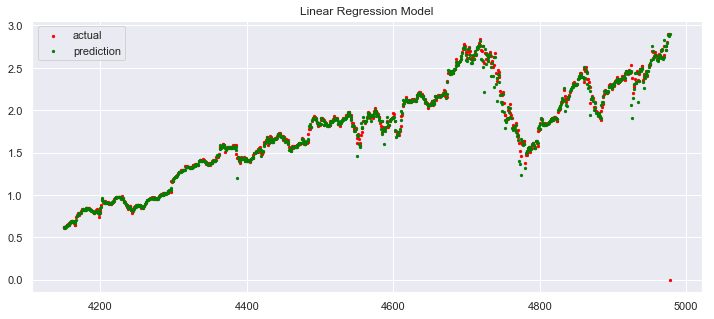

In [36]:
# scatter plot of actual prices and predictions
plt.figure(figsize=(12,5))

plt.scatter(x=test_index,y=y_test,s=5,color="red",label="actual")
plt.scatter(x=test_index,y=ypred_linReg,s=5,color="green",label="prediction")
plt.title("Linear Regression Model")

plt.legend()
plt.show()

### Plot (as a line) the regression and expected output, make the plot zoomable. What do you find, is the regression good? Comment in notebbok

In [37]:
tidy_df = pd.DataFrame(X,columns=["Open","High","Low","Close","Momentum","A/O Oscillator"])
tidy_df["label"] = y
tidy_df["Date"] = aapl_df.index
tidy_df = tidy_df.set_index("Date")
tidy_df.head()

Open      High       Low     Close  Momentum  A/O Oscillator  \
Date                                                                           
1999-12-31 -0.872530 -0.871393 -0.873342 -0.871393 -0.926441       -0.931631   
2000-01-03 -0.870094 -0.865710 -0.872043 -0.866035 -0.923681       -0.928708   
2000-01-04 -0.868146 -0.866847 -0.872368 -0.871556 -0.928228       -0.929663   
2000-01-05 -0.870744 -0.866847 -0.871231 -0.870744 -0.924493       -0.928533   
2000-01-06 -0.869445 -0.868958 -0.875940 -0.875940 -0.926441       -0.929103   

               label  
Date                  
1999-12-31 -0.866035  
2000-01-03 -0.871556  
2000-01-04 -0.870744  
2000-01-05 -0.875940  
2000-01-06 -0.873342

In [38]:
tidy_df = tidy_df.reset_index().melt(id_vars=["Date"])
px.line(tidy_df,x="Date",y="value",color="variable")

### Add 2 more features from the “Type 2” category of features presented in the paper (not MA).

In [40]:
# create a new feature as "ASY1"
aapl_df["ASY1"] = (np.log(aapl_df["Close"])-np.log(aapl_df["Close"].shift(-1)))*100
aapl_df["ASY1"] = aapl_df["ASY1"].fillna(aapl_df["ASY1"].mean())

# create a new feature as "OBV"
aapl_df["Teta"] = np.where(aapl_df["Close"]>=aapl_df["Close"].diff(),1,-1)
aapl_df["OBV"] = 0
for i in range(0,len(aapl_df)):
    aapl_df.OBV[i] = aapl_df.OBV[i-1]+(aapl_df.Teta[i]*aapl_df.Volume[i])

aapl_df.head()

C:\Users\alisa\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Open  High   Low  Close  Adj Close     Volume  Momentum  \
Date                                                                  
1999-12-31  3.60  3.67  3.55   3.67       3.20   40952800      0.28   
2000-01-03  3.75  4.02  3.63   4.00       3.49  133949200      0.45   
2000-01-04  3.87  3.95  3.61   3.66       3.19  128094400      0.17   
2000-01-05  3.71  3.95  3.68   3.71       3.24  194580400      0.40   
2000-01-06  3.79  3.82  3.39   3.39       2.96  191993200      0.28   

            A/O Oscillator  label      ASY1  Teta        OBV  
Date                                                          
1999-12-31         -0.0396   4.00 -8.610270    -1  -40952800  
2000-01-03          0.1404   3.66  8.883121     1   92996400  
2000-01-04          0.0816   3.71 -1.356873     1  221090800  
2000-01-05          0.1512   3.39  9.020196     1  415671200  
2000-01-06          0.1161   3.55 -4.611768     1  607664400

In [41]:
# X will be the featureset in form of np.array
X = np.array(aapl_df.drop(["Adj Close","Volume","label","Teta"],axis=1))

# y is the label set
y = np.array(aapl_df["label"])
y = y.reshape(len(y),1)

# fit standard scaler to y so both X and y are using same scale
scaler = preprocessing.StandardScaler().fit(y)
X = scaler.transform(X)
y = scaler.transform(y)

# splitting data into train and test
tscv = TimeSeriesSplit(n_splits=5)
for train_index,test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
X.shape, y.shape

((4979, 8), (4979, 1))

###### LinearRegression

In [42]:
# assign sklearn's model to a variable
linReg = LinearRegression()

In [43]:
# fit or train the model
linReg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [44]:
# score returns the coefficient of determination R^2 of the predection
linReg.score(X_test,y_test)

0.9638489015037803

In [45]:
# prediction by model
ypred_linReg = linReg.predict(X_test)

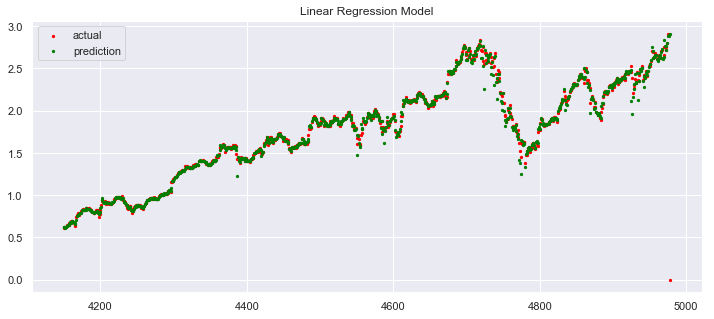

In [46]:
# scatter plot of actual prices and predictions
plt.figure(figsize=(12,5))

plt.scatter(x=test_index,y=y_test,s=5,color="red",label="actual")
plt.scatter(x=test_index,y=ypred_linReg,s=5,color="green",label="prediction")
plt.title("Linear Regression Model")

plt.legend()
plt.show()

In [48]:
tidy_df = pd.DataFrame(X,columns=["Open","High","Low","Close","Momentum","A/O Oscillator","ASY1","OBV"])
tidy_df["label"] = y
tidy_df["Date"] = aapl_df.index
tidy_df = tidy_df.set_index("Date")

tidy_df = tidy_df.reset_index().melt(id_vars=["Date"])
px.line(tidy_df,x="Date",y="value",color="variable")

### Calculate the error for the regression, use sMAPE/MAPE and MASE error measurements

In [49]:
# Forecast Error (or Residual Forecast Error)
forecast_error = y_test-ypred_linReg
forecast_error

array([[ 3.03085215e-03],
       [-9.63939941e-03],
       [ 5.69711209e-03],
       [ 2.57211401e-03],
       [ 9.03453259e-03],
       [ 4.23189124e-03],
       [ 2.95599603e-03],
       [-5.96003852e-03],
       [ 1.78883756e-02],
       [-2.65620163e-03],
       [ 1.45461540e-02],
       [ 3.23023932e-03],
       [ 1.30148593e-02],
       [ 4.42394075e-03],
       [-1.63467263e-02],
       [-2.36966136e-02],
       [-2.18029459e-02],
       [ 3.32842800e-02],
       [ 7.17007992e-03],
       [-3.60136027e-03],
       [ 2.23403029e-02],
       [-1.58385511e-02],
       [-1.11889090e-03],
       [-8.56355362e-04],
       [ 2.17340007e-02],
       [ 8.80713057e-03],
       [ 9.08594119e-03],
       [-5.25201132e-03],
       [-2.59143921e-03],
       [ 4.74192711e-04],
       [ 2.02109931e-02],
       [ 1.34999508e-03],
       [ 1.27782092e-03],
       [ 4.29971345e-03],
       [ 1.06107769e-02],
       [-2.45571195e-03],
       [ 8.67958813e-03],
       [-1.52735673e-03],
       [ 1.3

In [50]:
# Mean Forecast Error (or Forecast Bias) 
mfe = np.mean(forecast_error)
mfe

0.0028901430297377114

In [51]:
# Mean Absolute Error
mae = np.mean(np.abs(forecast_error))
mae

0.02100482225929883

In [52]:
# Mean Squared Error
mse = np.mean(forecast_error**2)
mse

0.011586796122134162

In [53]:
# Root Mean Squared Error
rmse = np.sqrt(mse)
rmse

0.10764198122542228

In [54]:
# MAPE
mape = np.mean(np.abs(y_test-ypred_linReg)/np.abs(y_test))*100
mape

506451616803189.4

In [55]:
# sMAPE
smape = np.mean(2*np.abs(y_test-ypred_linReg)/(np.abs(y_test))+(np.abs(ypred_linReg)))*100
smape

1012903233606555.1

In [77]:
# MASE

### Design a decision for when to invest and when to sell based on your regression. The decision can be naïve, meaning you can create a rule (if .. X .. then .. Y). Compare correctness for the result between train and test data. Follow the paper for calculating hit ratio % (buy or sell)

In [91]:
hit_df = pd.DataFrame({"Actual":y_test.reshape(-1),"Prediction":ypred_linReg.reshape(-1),"index":test_index},index=test_index)
hit_df["Actual"] = hit_df["Actual"].diff()
hit_df["Prediction"] = hit_df["Prediction"].diff()
hit_df["Hit"] = np.where(hit_df["Actual"]*hit_df["Prediction"]>0,1.0,0.0)
hit_df.head()

Actual  Prediction  index  Hit
4150       NaN         NaN   4150  0.0
4151 -0.014615   -0.001944   4151  1.0
4152  0.008769   -0.006568   4152  0.0
4153  0.006658    0.009783   4153  1.0
4154  0.012016    0.005554   4154  1.0

In [92]:
hit_melt = hit_df.melt(id_vars='index',value_vars=['Actual','Prediction'])
px.line(hit_melt,x='index',y='value',color='variable')

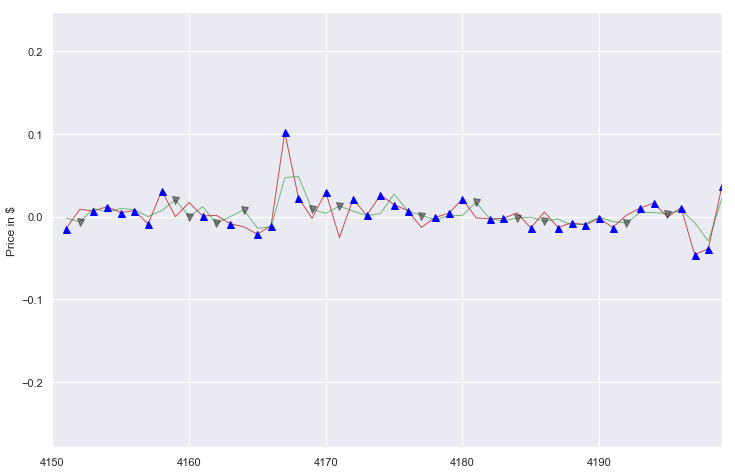

In [101]:
# initialize the plotfigure
fig = plt.figure(figsize=(12,8))

# add a subplot and label for y-axis
ax1 = fig.add_subplot(111,ylabel="Price in $")

# plot AAPL closing prices
hit_df["Actual"][:50].plot(ax=ax1,color="r",lw=1)

# plot the short and long moving averages
hit_df["Prediction"][:50].plot(ax=ax1,color="green",alpha=0.5,lw=1)

# plot the buy signals
ax1.plot(hit_df.loc[hit_df.Hit==1.0].index,
         hit_df.Actual[hit_df.Hit==1.0],
         "^",markersize=7,color="blue")

# plot the sell signals
ax1.plot(hit_df.loc[hit_df.Hit==0.0].index,
         hit_df.Prediction[hit_df.Hit==0.0],
         "v",markersize=7,color="k",alpha=0.5)

plt.show()